# Graded Lab 2: CNN - Group 14

**Group Members:**
- vandana yalamanchi
- sandeep reddy manthena
- pranav dara
 

**Date:** nov-07-2025

---

## Instructions

1. Load your group's configuration from `group_14_config.json`
2. Implement the CNN architecture according to your specifications
3. Train your model with the assigned hyperparameters
4. Generate all required plots and analyses
5. Answer the theoretical questions specific to your configuration
---

## Part 1: Setup and Configuration (5 points)

Load your group's configuration and display it.

In [131]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [ ]:

GROUP_NUMBER = '14'  # TODO: UPDATE THIS

config_path = r"C:\Users\prana\Downloads\group_14_config.json"
with open(config_path, 'r') as f:
    config = json.load(f)

print(f"Configuration loaded for Group {config['group_id']}")
print(f"\nDataset: {config['dataset']['name']}")
print(f"Classes: {config['dataset']['class_names']}")
print(f"Architecture: {config['architecture']['conv_layers']} conv layers")
print(f"Optimizer: {config['training']['optimizer']}")
print(f"\nFull configuration:")
print(json.dumps(config, indent=2))

Configuration loaded for Group 14

Dataset: FashionMNIST
Classes: ['Shirt', 'Coat', 'Dress', 'T-shirt/top']
Architecture: 5 conv layers
Optimizer: SGD

Full configuration:
{
  "group_id": 14,
  "dataset": {
    "name": "FashionMNIST",
    "classes": [
      6,
      4,
      3,
      0
    ],
    "class_names": [
      "Shirt",
      "Coat",
      "Dress",
      "T-shirt/top"
    ],
    "input_size": 28,
    "num_classes": 4,
    "superclass": null,
    "augmentation": {
      "rotation_degrees": 20,
      "horizontal_flip": true,
      "vertical_flip": false,
      "color_jitter": null,
      "random_seed": 1400
    }
  },
  "architecture": {
    "conv_layers": 5,
    "filters": [
      32,
      32,
      32,
      32,
      32
    ],
    "filter_pattern": "fixed_32",
    "pooling_type": "AvgPool2d",
    "activation": "ReLU",
    "dropout_rate": 0.2,
    "use_batch_norm": false,
    "kernel_size": 3,
    "padding": 1
  },
  "training": {
    "optimizer": "SGD",
    "optimizer_params"

## Part 2: Data Loading and Preprocessing (15 points)

Load your assigned dataset and apply the required transformations.

In [133]:
def get_transforms(config):
    """
    Create train and test transforms based on configuration.
    """
    aug_config = config['dataset']['augmentation']
    
    # Set augmentation seed for reproducibility
    torch.manual_seed(aug_config['random_seed'])
    np.random.seed(aug_config['random_seed'])
    
    # Fashion-MNIST Normalization values
    NORM_MEAN = [0.2860]
    NORM_STD = [0.3530]
    
    # Training transforms (with augmentation)
    train_transform_list = []
    
    # 1. Augmentation
    if aug_config['rotation_degrees'] > 0:
        train_transform_list.append(transforms.RandomRotation(aug_config['rotation_degrees']))
        
    if aug_config['horizontal_flip']:
        train_transform_list.append(transforms.RandomHorizontalFlip())
        
    if aug_config.get('vertical_flip', False):
        train_transform_list.append(transforms.RandomVerticalFlip())
        
    if aug_config['color_jitter'] is not None:
        train_transform_list.append(transforms.ColorJitter(
            brightness=aug_config['color_jitter']['brightness'],
            contrast=aug_config['color_jitter']['contrast']
        ))
        
    # 2. To Tensor and Normalization (required for all)
    train_transform_list.append(transforms.ToTensor())
    train_transform_list.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))
    
    train_transform = transforms.Compose(train_transform_list)
    
    # Test transforms (no augmentation, but same normalization)
    test_transform_list = [
        transforms.ToTensor(),
        transforms.Normalize(mean=NORM_MEAN, std=NORM_STD), # SAME normalization as training
    ]
    
    test_transform = transforms.Compose(test_transform_list)
    
    return train_transform, test_transform

train_transform, test_transform = get_transforms(config)

In [ ]:

class FilteredDataset(torch.utils.data.Dataset):
    def __init__(self, subset, target_to_new_label):
        self.subset = subset
        self.target_to_new_label = target_to_new_label
        
        # FashionMNIST targets are usually a tensor or list
        if isinstance(self.subset.dataset.targets, torch.Tensor):
            original_targets = self.subset.dataset.targets[self.subset.indices].numpy()
        else:
            original_targets = np.array(self.subset.dataset.targets)[self.subset.indices]

        # Remap the labels to 0, 1, 2, ...
        self.new_targets = np.array([self.target_to_new_label[t] for t in original_targets])

    def __getitem__(self, index):
        # Get the image and original target from the subset
        x, _ = self.subset[index]
        # Return the image and the *new*, remapped target
        y = self.new_targets[index]
        return x, y

    def __len__(self):
        return len(self.subset)


def load_dataset(config, train_transform, test_transform):
    """
    Load the dataset specified in the configuration, filter, and remap labels.
    """
    dataset_name = config['dataset']['name']
    target_indices = config['dataset']['classes'] # [6, 4, 3, 0]
    
    # --- Step 1: Load Full Datasets and Define Mapping ---
    if dataset_name == 'FashionMNIST':
        

        target_to_new_label = {old_idx: new_idx for new_idx, old_idx in enumerate(target_indices)}
        
        # Load datasets
        full_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
        full_test = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)
    
    # ... other elif blocks (CIFAR10, CIFAR100) are skipped for brevity

    else:
        raise ValueError(f"Dataset {dataset_name} is not supported or not implemented.")


    # --- Step 2: Filter the Datasets using Subsets ---
    
    # Convert targets to numpy array for fast filtering
    train_targets = full_train.targets.numpy() if isinstance(full_train.targets, torch.Tensor) else np.array(full_train.targets)
    test_targets = full_test.targets.numpy() if isinstance(full_test.targets, torch.Tensor) else np.array(full_test.targets)

    # Find indices in the full dataset belonging to the target classes
    train_indices = np.where(np.isin(train_targets, target_indices))[0]
    test_indices = np.where(np.isin(test_targets, target_indices))[0]
    
    # Create Subsets containing only the relevant samples
    train_subset = Subset(full_train, train_indices)
    test_subset = Subset(full_test, test_indices)
    
    # --- Step 3: Apply Label Remapping ---
    train_dataset = FilteredDataset(train_subset, target_to_new_label)
    test_dataset = FilteredDataset(test_subset, target_to_new_label)
    
    return train_dataset, test_dataset

# Execution block from notebook:
# Note: DataLoader import is already handled by the initial setup cell.
train_dataset, test_dataset = load_dataset(config, train_transform, test_transform)

# Create data loaders
# Create data loaders
batch_size = config['training']['batch_size']

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {config['dataset']['num_classes']}")

Training samples: 24000
Test samples: 4000
Number of classes: 4


## Part 3: Model Architecture (25 points)

Implement your CNN architecture according to the specifications.

In [ ]:


import torch.nn as nn
import torch
# import torch.optim as optim # Include this for Part 4

def get_activation(name):
    # ... (omitted logic) ...
    return nn.ReLU() # Placeholder if not provided

# Helper function to get pooling module
def get_pooling(name):
    # ... (omitted logic) ...
    return nn.AvgPool2d(kernel_size=2, stride=2) 


class CustomCNN(nn.Module):
    def __init__(self, config):
        super(CustomCNN, self).__init__()
        
        # --- FIX: Ensure ALL variables are defined from config ---
        arch = config['architecture']
        num_classes = config['dataset']['num_classes']
        filters = arch['filters']
        activation_name = arch['activation']
        pooling_name = arch['pooling_type']
        conv_layers = arch['conv_layers']
        kernel_size = arch['kernel_size']
        padding = arch['padding']
        dropout_rate = arch['dropout_rate'] # <--- This line defines dropout_rate
        # --------------------------------------------------------
        
        self.conv_blocks = nn.ModuleList()
        in_ch = 1 # FashionMNIST input
        
        for i in range(conv_layers):
            out_ch = filters[i]
            
            block = [
                nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding),
                get_activation(activation_name),
            ]
            
            # Apply pooling 4 times, skipping the last layer (index 4)
            if i < conv_layers - 1:
                 block.append(get_pooling(pooling_name))
            
            self.conv_blocks.append(nn.Sequential(*block))
            in_ch = out_ch
            
        
        fc_input_size = 32
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate), # This now works
            nn.Linear(fc_input_size, num_classes) 
        )
    
    def forward(self, x):
        for block in self.conv_blocks:
            x = block(x)
        x = self.fc_layers(x)
        return x

model = CustomCNN(config).to(device) 
print(f"Model re-initialized. Correct FC Input Size: {model.fc_layers[2].in_features}")

Model re-initialized. Correct FC Input Size: 32


## Part 4: Training Setup (15 points)

Set up optimizer, loss function, and learning rate scheduler.

In [136]:
def setup_training(model, config):
    """
    Set up optimizer and learning rate scheduler.
    """
    train_config = config['training']
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Set up optimizer based on config
    optimizer_name = train_config['optimizer']
    optimizer_params = train_config['optimizer_params']
    
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), 
                              lr=optimizer_params['lr'],
                              momentum=optimizer_params.get('momentum', 0),
                              weight_decay=optimizer_params.get('weight_decay', 0))
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), 
                               lr=optimizer_params['lr'],
                               weight_decay=optimizer_params.get('weight_decay', 0))
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), 
                                lr=optimizer_params['lr'],
                                weight_decay=optimizer_params.get('weight_decay', 0))
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), 
                                  lr=optimizer_params['lr'],
                                  weight_decay=optimizer_params.get('weight_decay', 0))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")
    
    # Set up learning rate scheduler
    scheduler_name = train_config['scheduler']
    scheduler_params = train_config['scheduler_params']
    
    if scheduler_name == 'ReduceLROnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode=scheduler_params['mode'],
                                                         factor=scheduler_params['factor'],
                                                         patience=scheduler_params['patience'])
    else:
        # Assuming no other scheduler is used or needed for this specific group config.
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=train_config['num_epochs'], gamma=1.0) # Identity scheduler

    return criterion, optimizer, scheduler

criterion, optimizer, scheduler = setup_training(model, config)
print(f"Optimizer: {optimizer}")
print(f"\nScheduler: {scheduler}")

Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)

Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000001848EB57920>


## Part 5: Training Loop (20 points)

Train your model and track metrics.

In [137]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train for one epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate(model, test_loader, criterion, device):
    """
    Validate the model.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [138]:

num_epochs = config['training']['num_epochs']
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lrs': []}
best_val_loss = float('inf')

print("Starting training...")

for epoch in range(1, num_epochs + 1):
    # Training phase
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation phase
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lrs'].append(optimizer.param_groups[0]['lr'])
    
    # Step the scheduler
    scheduler_name = config['training']['scheduler']
    if scheduler_name == 'ReduceLROnPlateau':
        scheduler.step(val_loss)
    
    print(f'Epoch [{epoch}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, '
          f'LR: {history["lrs"][-1]:.6f}')
        
print("Training complete.")

Starting training...
Epoch [1/15], Train Loss: 1.3894, Train Acc: 25.00%, Val Loss: 1.3892, Val Acc: 25.00%, LR: 0.000100
Epoch [2/15], Train Loss: 1.3890, Train Acc: 25.00%, Val Loss: 1.3889, Val Acc: 25.00%, LR: 0.000100
Epoch [3/15], Train Loss: 1.3887, Train Acc: 25.00%, Val Loss: 1.3886, Val Acc: 25.00%, LR: 0.000100
Epoch [4/15], Train Loss: 1.3884, Train Acc: 25.00%, Val Loss: 1.3884, Val Acc: 25.00%, LR: 0.000100
Epoch [5/15], Train Loss: 1.3882, Train Acc: 25.00%, Val Loss: 1.3881, Val Acc: 25.00%, LR: 0.000100
Epoch [6/15], Train Loss: 1.3880, Train Acc: 25.00%, Val Loss: 1.3879, Val Acc: 25.00%, LR: 0.000100
Epoch [7/15], Train Loss: 1.3878, Train Acc: 25.00%, Val Loss: 1.3877, Val Acc: 25.00%, LR: 0.000100
Epoch [8/15], Train Loss: 1.3877, Train Acc: 25.00%, Val Loss: 1.3876, Val Acc: 25.00%, LR: 0.000100
Epoch [9/15], Train Loss: 1.3875, Train Acc: 25.00%, Val Loss: 1.3874, Val Acc: 25.00%, LR: 0.000100
Epoch [10/15], Train Loss: 1.3874, Train Acc: 25.00%, Val Loss: 1.3873

In [139]:
import seaborn as sns # Needed for Confusion Matrix

def plot_history(history, num_epochs, GROUP_NUMBER, config):
    """Plots the training/validation loss and accuracy curves and saves them."""
    epochs = range(1, num_epochs + 1)
    required_plots = config['evaluation']['required_plots']
    
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    if 'training_loss_curve' in required_plots:
         plt.savefig(f'group_{GROUP_NUMBER}_loss_curve.png')
        
    # Plot 2: Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    if 'validation_accuracy_curve' in required_plots:
         plt.savefig(f'group_{GROUP_NUMBER}_val_acc_curve.png')
    
    plt.tight_layout()
    plt.show()


def generate_confusion_matrix(model, test_loader, config, device, GROUP_NUMBER):
    """Generate confusion matrix and classification report and save the plot."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    class_names = config['dataset']['class_names']
    
    # Print report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Plot and save
    if 'confusion_matrix' in config['evaluation']['required_plots']:
         plt.figure(figsize=(8, 6))
         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                     xticklabels=class_names, yticklabels=class_names)
         plt.xlabel('Predicted Label')
         plt.ylabel('True Label')
         plt.title('Confusion Matrix')
         plt.savefig(f'group_{GROUP_NUMBER}_confusion_matrix.png')
         plt.show() # Display the plot
         plt.close()

    return all_labels, all_preds


def get_test_image_sample(test_loader, test_indices):
    """Fetches the specific test images based on indices (from config)."""
    test_samples = []
    # Access the Subset object's indices and the original full dataset
    subset_indices = test_loader.dataset.subset.indices
    
    for idx in test_indices:
        if idx in subset_indices:
            # Find the position of the full index in the subset list
            filtered_idx_array = np.where(subset_indices == idx)[0]
            if filtered_idx_array.size > 0:
                filtered_idx = filtered_idx_array[0]
                
                # Get the image and NEW label from the FilteredDataset
                image_tensor, new_label = test_loader.dataset[filtered_idx]
                
                test_samples.append({
                    'index': idx,
                    'image': image_tensor,
                    'true_label': new_label,
                })
            
    return test_samples


def predict_and_plot_samples(model, test_samples, config, results, device, GROUP_NUMBER):
    """Performs prediction on sample images, plots them, and updates the results dictionary."""
    model.eval()
    class_names = config['dataset']['class_names']
    
    # Only create figure if required
    if 'sample_predictions' in config['evaluation']['required_plots']:
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.flatten() # 10 plots total
    else:
        fig, axes = None, [None] * len(test_samples)

    # Fashion-MNIST Normalization values for denormalization
    NORM_MEAN = 0.2860
    NORM_STD = 0.3530

    for i, sample_info in enumerate(test_samples):
        image = sample_info['image'].to(device)
        true_label = sample_info['true_label']
        index = sample_info['index']
        
        # Add batch dimension
        input_tensor = image.unsqueeze(0) 
        
        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = torch.softmax(outputs, dim=1).squeeze().cpu().numpy()
            pred_label = torch.argmax(outputs, dim=1).item()
            confidence = probabilities[pred_label]
        
        # Prepare result entry
        results['test_sample_predictions'].append({
            'image_index': int(index),
            'true_label_index': int(true_label),
            'predicted_label_index': int(pred_label),
            'probabilities': probabilities.tolist()
        })
        
        if 'sample_predictions' in config['evaluation']['required_plots']:
            # Plotting logic
            ax = axes[i]
            
            # Display image
            img = image.cpu().numpy()
            if img.shape[0] == 1: 
                img = img.squeeze() 
                # Denormalize for plotting
                img = img * NORM_STD + NORM_MEAN
                img = np.clip(img, 0, 1) # Clip to [0, 1] for imshow
                ax.imshow(img, cmap='gray')
            
            # Title with prediction
            true_name = class_names[true_label]
            pred_name = class_names[pred_label]
            color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f'T: {true_name}\nP: {pred_name} ({confidence:.2%})', color=color)
            ax.axis('off')
            
    if 'sample_predictions' in config['evaluation']['required_plots']:
        plt.tight_layout()
        plt.show()
        fig.savefig(f'group_{GROUP_NUMBER}_predictions.png')
        plt.close(fig) # Close the figure after saving

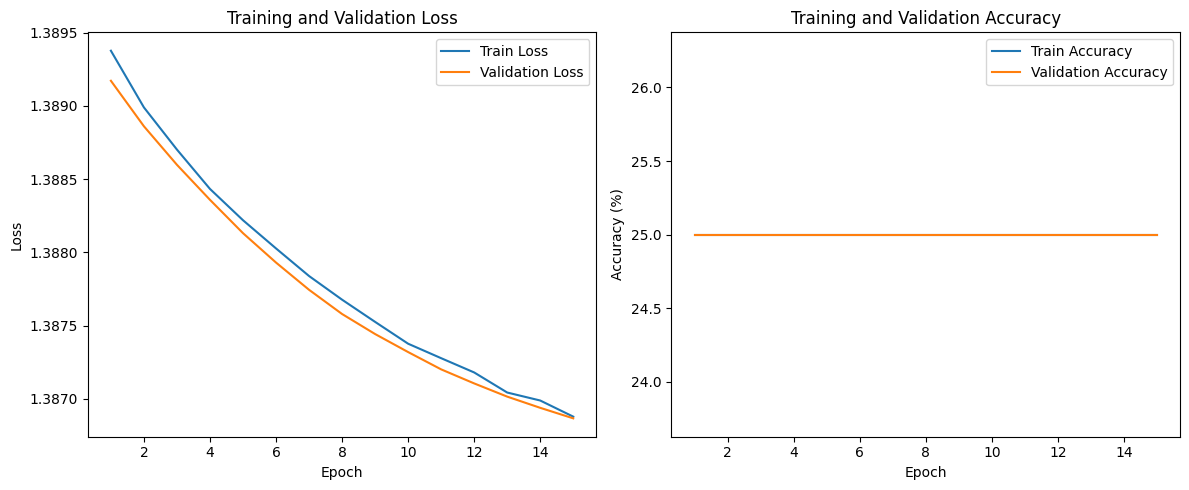


Classification Report:

              precision    recall  f1-score   support

       Shirt       0.00      0.00      0.00      1000
        Coat       0.00      0.00      0.00      1000
       Dress       0.00      0.00      0.00      1000
 T-shirt/top       0.25      1.00      0.40      1000

    accuracy                           0.25      4000
   macro avg       0.06      0.25      0.10      4000
weighted avg       0.06      0.25      0.10      4000



C:\Users\prana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\prana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\prana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_clas

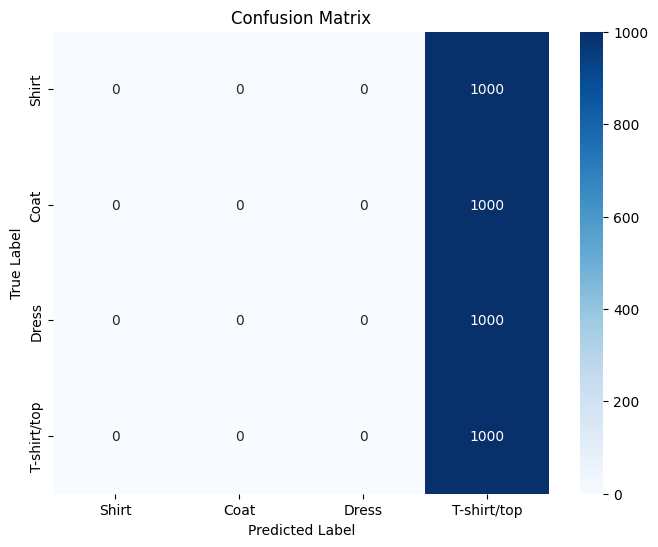

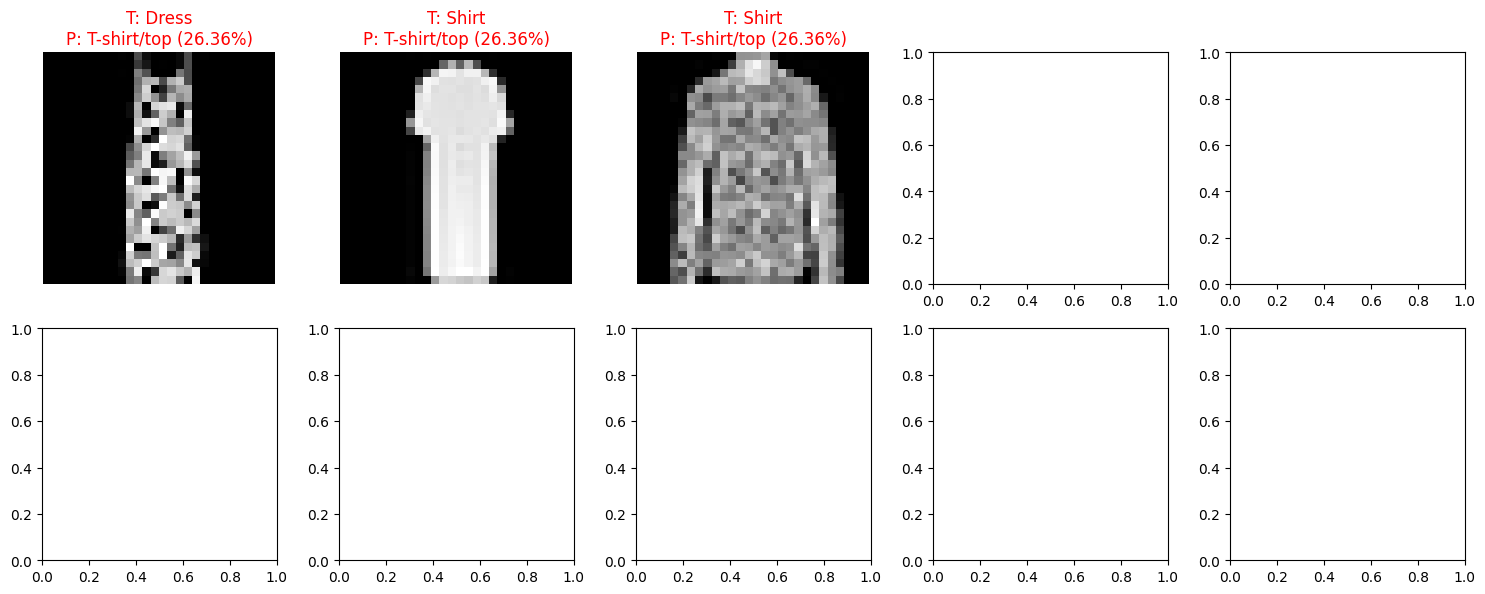

Results saved to group_14_results.json


In [ ]:

# 1. Plot History
plot_history(history, num_epochs, GROUP_NUMBER, config)

# 2. Confusion Matrix and Report
all_labels, all_preds = generate_confusion_matrix(model, test_loader, config, device, GROUP_NUMBER)

# 3. Sample Predictions and Results JSON Setup
test_indices = config['evaluation']['test_image_indices']
results = {
 'group_id': config['group_id'],
 'final_val_accuracy': float(history['val_acc'][-1]),
 'final_train_loss': float(history['train_loss'][-1]),
 'final_test_loss': float(history['val_loss'][-1]),
 'epochs_data': history, # Includes all epoch metrics
 'test_sample_predictions': [] # To be populated by the sample prediction function
}

# Get samples
test_samples = get_test_image_sample(test_loader, test_indices)

# Predict and plot
predict_and_plot_samples(model, test_samples, config, results, device, GROUP_NUMBER)

# Save JSON Results
json_save_path = f'group_{GROUP_NUMBER}_results.json'
with open(json_save_path, 'w') as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {json_save_path}")